1. Librerías necesarias

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats



AJUSTE DISTRIBUCIÓN

In [3]:
demand_data = np.array([
    173, 212, 225, 199, 205, 176, 215, 198, 198, 184,
    199, 211, 233, 195, 217, 209, 177, 161, 175, 209,
    197, 206, 167, 196, 205, 219, 184, 172, 207, 191,
    164, 216, 163, 236, 183, 213, 195, 182, 238, 141,
    178, 211, 165, 213, 186, 202, 186, 194, 210, 206,
    196, 197, 236, 173, 199, 211, 168, 181, 206, 216,
    196, 201, 180, 209, 176, 221, 190, 206, 190, 210
])

estadística descriptiva

In [4]:
media= np.mean(demand_data)
mediana = np.median(demand_data)
desviacionstd = np.std(demand_data)
minimo = np.min(demand_data)
maximo = np.max(demand_data)
curtuosis = stats.kurtosis(demand_data)
print ("Media: ", media)
print ("Mediana: ", mediana)
print ("Curtuosis: ", curtuosis)

Media:  196.55714285714285
Mediana:  198.0
Curtuosis:  -0.13160850750515474


ajuste distribución normal

In [5]:
mu, sigma = stats.norm.fit(demand_data)

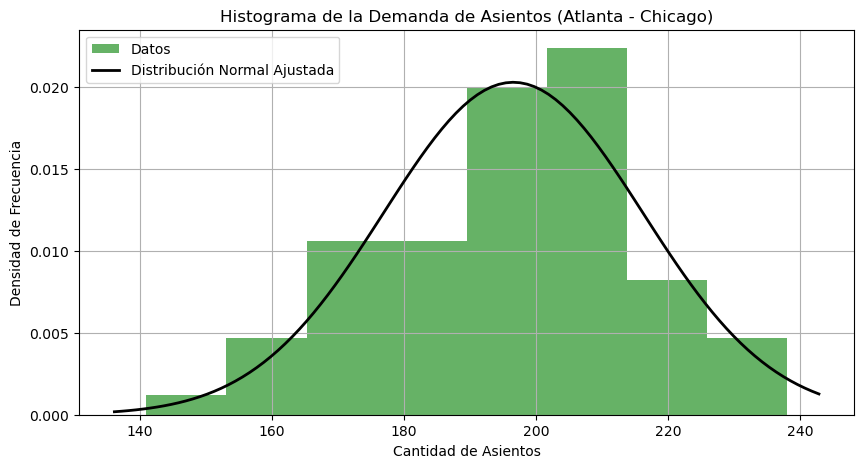

In [6]:
plt.figure(figsize=(10, 5))
plt.hist(demand_data, bins="sturges", density=True, alpha=0.6, color='g', label="Datos")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2, label="Distribución Normal Ajustada")
plt.title("Histograma de la Demanda de Asientos (Atlanta - Chicago)")
plt.xlabel("Cantidad de Asientos")
plt.ylabel("Densidad de Frecuencia")
plt.legend()
plt.grid()
plt.show()

Intentamos la normal ya que la media: 196.5 y la mediana: 198 son valores cercanos, lo que nos indica que puede ser una distribución simétrica

TRIANGULAR

In [7]:
a = minimo
b = maximo
c = stats.mode(demand_data).mode #valor mas frecuente
print(a,b,c)

141 238 206


In [8]:
dist_triangular = stats.triang(c=(c-a)/(b-a), loc=a, scale=(b-a))

histograma

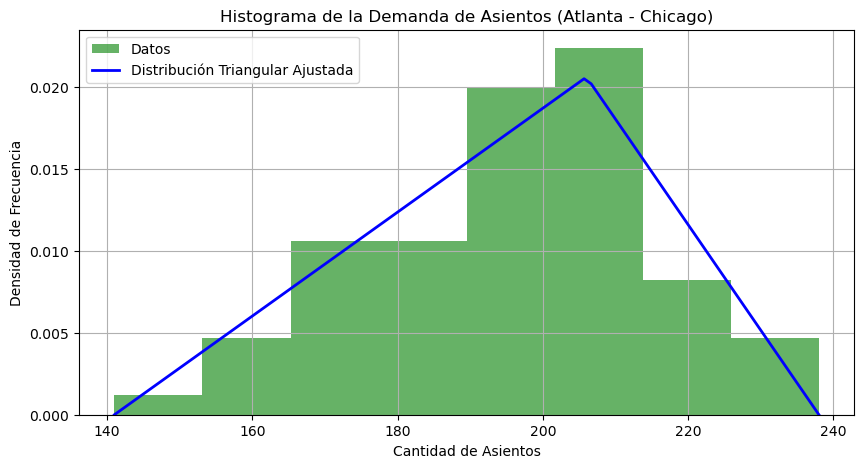

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(demand_data, bins="sturges", density=True, alpha=0.6, color='g', label="Datos")
x = np.linspace(a, b, 100)
plt.plot(x, dist_triangular.pdf(x), 'b-', linewidth=2, label="Distribución Triangular Ajustada")
plt.title("Histograma de la Demanda de Asientos (Atlanta - Chicago)")
plt.xlabel("Cantidad de Asientos")
plt.ylabel("Densidad de Frecuencia")
plt.legend()
plt.grid()
plt.show()

Prueba de ajuste de bondad  Kolmogorov-Smirnov

In [10]:
# Para la normal: 
ks_norm_stat, ks_norm_pvalor = stats.kstest(demand_data, 'norm', args=(mu, sigma))

In [11]:
# Para la triangular:
c_param = (c-a)/(b-a)
ks_tri_stat, ks_tri_pvalue = stats.kstest(demand_data, 'triang', args=(c_param, a, b-a))

In [12]:
comparison_df = pd.DataFrame({
    'Distribución': ['Normal', 'Triangular'],
    'KS Estadístico': [ks_norm_stat, ks_tri_stat],
    'KS P-valor': [ks_norm_pvalor, ks_tri_pvalue]
})

comparison_df



,Distribución,KS Estadístico,KS P-valor
0,Normal,0.082714,0.693173
1,Triangular,0.076776,0.774804


Como el KS estadístico de la triangular es menor que la normal, y el valor P es mayor en la triangular que la normal, consideramos que la distribución que mejor se ajusta es la triangular.

2. Entradas conocidas

In [26]:
precios = {
    "Boston-Atlanta": {"Primera": 400, "Turista": 175},
    "Atlanta-Chicago": {"Primera": 400, "Turista": 150},
    "Chicago-Boston": {"Primera": 450, "Turista": 200},
}

COSTO_FIJO= 100000

# 3 filas primera clase,34 turista

FILAS_PRIMERA = 3
FILAS_TURISTA = 34
CAPACIDAD_PRIMERA = FILAS_PRIMERA*4
CAPACIDAD_TURISTA = FILAS_TURISTA*6

fracciones_primeraclase=[0.05, 0.12, 0.15]
probabilidades_primeraclase=[0.2, 0.5, 0.3]



3. Variables de decisión


4. Entradas inciertas

<Axes: ylabel='Density'>

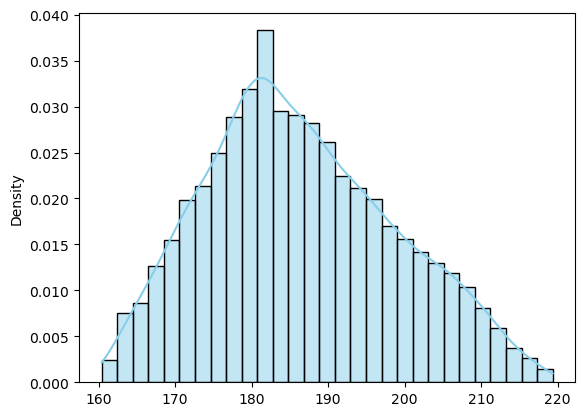

In [14]:
X = stats.triang(c=(180-160)/(220-160), loc=160, scale=(220-160)).rvs(5000)
sns.histplot(X, kde=True, stat="density", color="skyblue")

In [15]:
# demandas por cada tramo
demanda_tramos = {
    "Boston-Atlanta": stats.triang(c=(180-160)/(220-160), loc=160, scale=(220-160)),
    "Atlanta-Chicago": stats.triang(c=(c-a)/(b-a), loc=a, scale=(b-a)),
    "Chicago-Boston": stats.triang(c=(200-150)/(225-150), loc=150, scale=(225-150)),
}


Cálculos intermedios

In [ ]:
def simulacion_beneficio(n_simulaciones=10000):
    beneficios = []
    for _ in range(n_simulaciones):
        ingreso_total = 0
        for tramo, dist_demanda in demanda_tramos.items():
            demanda_total = int(dist_demanda.rvs())  # Simular demanda total del tramo
            fraccion_pc = np.random.choice(fracciones_primeraclase, p=probabilidades_primeraclase)  # Fracción de primera clase
            
            demanda_pc = int(fraccion_pc * demanda_total)
            demanda_turista = demanda_total - demanda_pc
            
            # Determinar ocupación efectiva
            ocupados_pc = min(demanda_pc, CAPACIDAD_PRIMERA)
            ocupados_turista = min(demanda_turista, CAPACIDAD_TURISTA)
            
            # Calcular ingresos
            ingreso_pc = ocupados_pc * precios[tramo]["Primera"]
            ingreso_turista = ocupados_turista * precios[tramo]["Turista"]
            
            ingreso_total += ingreso_pc + ingreso_turista
        
        # Calcular beneficio neto
        beneficio = ingreso_total - COSTO_FIJO
        beneficios.append(beneficio)
    
    # Estadísticas del beneficio esperado
    return beneficios

In [32]:

beneficio_esperado=np.mean(simulacion_beneficio())
print("Beneficio esperado: ", beneficio_esperado)


Beneficio esperado:  2967.62
